## Lets start:
### Reading in the data:
We use xarray here, but you can also use e.g. iris or even pyaerocom

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

path='../../data_sample/wrf_out.small.h5'
ds = xr.open_dataset(path)

Check how your dataset looks

In [4]:
#lets check how the dataset looks like
ds

<xarray.Dataset>
Dimensions:  (XTIME: 1449, bottom_top: 10, south_north: 17, west_east: 23)
Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
  * XTIME    (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    P        (XTIME, bottom_top, south_north, west_east) float32 ...
    V        (XTIME, bottom_top, south_north, west_east) float32 ...
    U        (XTIME, bottom_top, south_north, west_east) float32 ...
    T        (XTIME, bottom_top, south_north, west_east) float32 ...

Assign attributes! Nice for plotting and to keep track of what is in your dataset (especially 'units' and 'standard_name'/'long_name' will be looked for by xarray. 

**Check the attributes! Can be useful info here:**

In [5]:
ds['XTIME']

<xarray.DataArray 'XTIME' (XTIME: 1449)>
array(['2017-12-02T00:00:00.000000000', '2017-12-02T03:00:00.000000000',
       '2017-12-02T06:00:00.000000000', ..., '2018-05-31T18:00:00.000000000',
       '2018-05-31T21:00:00.000000000', '2018-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
Attributes:
    FieldType:    104
    MemoryOrder:  0  
    description:  minutes since 2017-12-02 00:00:00
    stagger:      

In [6]:
# lets process potential temperature into C
ds['T_C'] = ds['T'] + 300 - 273
ds['T_C'] = ds['T_C'].assign_attrs({'units': 'C'})

Easier to type if we define some names:

In [16]:
#lets define some constants for the variable names so that calling them is easier.
BT  = 'bottom_top'
ilev = 'bottom_top'
SN  = 'south_north'
WE  = 'west_east'
XT  = 'XTIME'
time = 'XTIME'
XLA = 'XLAT'
lat = 'XLAT'
XLO = 'XLONG'
lon = 'XLONG'
P, V, U, T = 'P','V','U','T'

#this is potential temperature in C
T_C = 'T_C'

## Plotting

### Statistics:

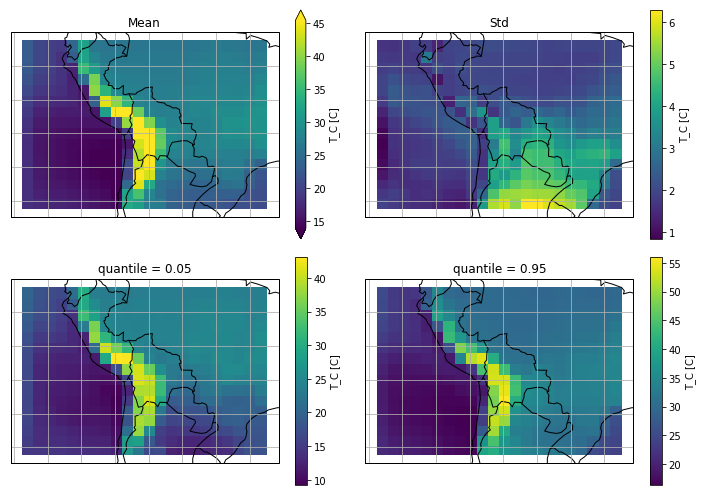

In [12]:
import cartopy.crs as ccrs
import cartopy as cy
fig, axsm = plt.subplots(2,2, figsize=[10,7], subplot_kw={'projection':ccrs.PlateCarree()})
axs = axsm.flatten()
_ds = ds[T_C][{BT:0}]
_ds.mean(time, keep_attrs=True).plot(x=lon, y=lat,ax=axs[0], transform=ccrs.PlateCarree(), robust=True)
axs[0].set_title('Mean')
_ds.std(time, keep_attrs=True).plot(x=lon, y=lat,ax=axs[1], transform=ccrs.PlateCarree())#, robust=True)
axs[1].set_title('Std')
_ds.quantile(0.05, dim=time, keep_attrs=True).plot(x=lon, y=lat,ax=axs[2], transform=ccrs.PlateCarree())#, robust=True)
_ds.quantile(0.95, dim=time, keep_attrs=True).plot(x=lon, y=lat,ax=axs[3], transform=ccrs.PlateCarree())#, robust=True)
for ax in axs:
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
plt.tight_layout()

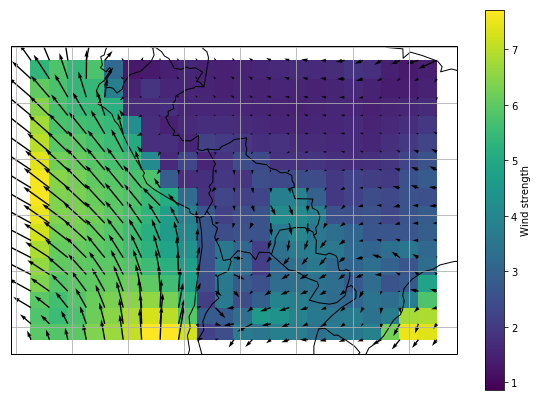

In [13]:
import cartopy.crs as ccrs
import cartopy as cy
fig, ax = plt.subplots(1, figsize=[10,7], subplot_kw={'projection':ccrs.PlateCarree()})
#axs = axsm.flatten()
WS = 'Wind strength'
ds[WS] = np.sqrt(ds[U]**2+ ds[V]**2)
ds[WS].attrs['units']='m/s'
ds[WS].attrs['name']='Wind strength'

_ds = ds[[U,V, WS]][{BT:0}].mean(XT)
_ds[WS].plot(x=XLO,y=XLA, transform=ccrs.PlateCarree())
ax.quiver(_ds[lon], _ds[lat], _ds['U'],_ds['V'], transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines()
ax.add_feature(cy.feature.BORDERS);
#plt.tight_layout()

### Tired of making plots:

In [14]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)
    
def add_map_features(ax):
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);



/home/sarambl/anaconda3/envs/general/lib/python3.6/site-packages/xarray/core/common.py:608: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


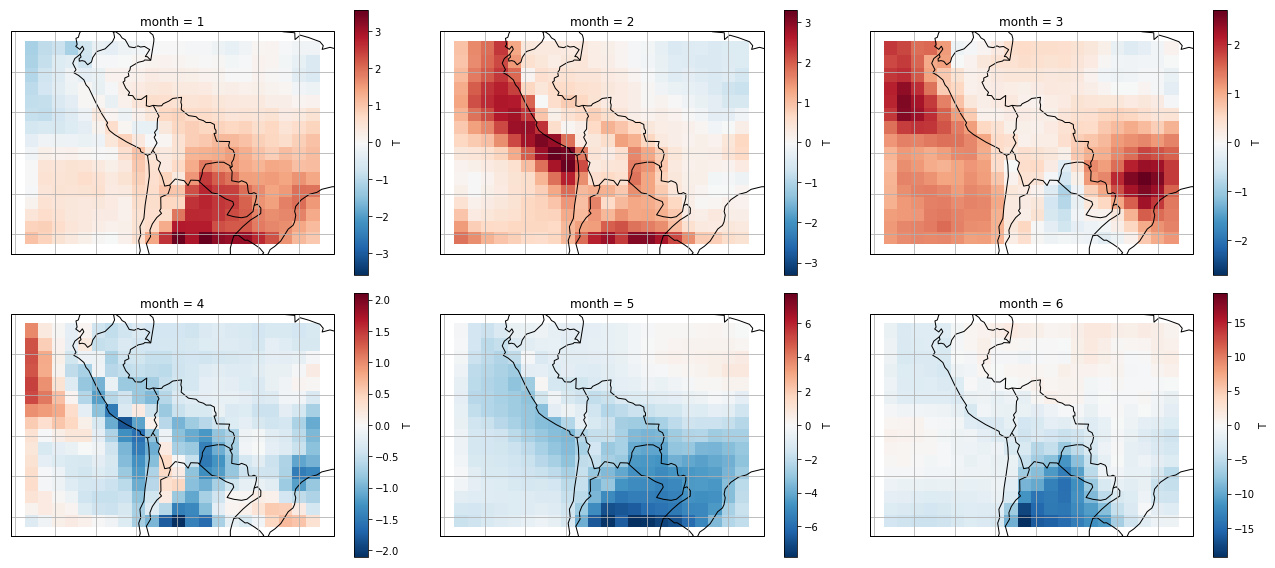

In [15]:
fig, axs = sp_map(2,3, figsize=[18,8])

T_mm = ds[T][{BT:0}].groupby('XTIME.month').mean(XT)
T_mean = ds[T][{BT:0}].mean(XT)
T_dev = T_mm- T_mean
T_mm.sel(month=1)
for mo, ax in zip(T_mm['month'], axs.flatten()):
    T_dev.sel(month=mo).plot(x=XLO, y=XLA,ax=ax, transform=ccrs.PlateCarree())
    add_map_features(ax)
plt.tight_layout()

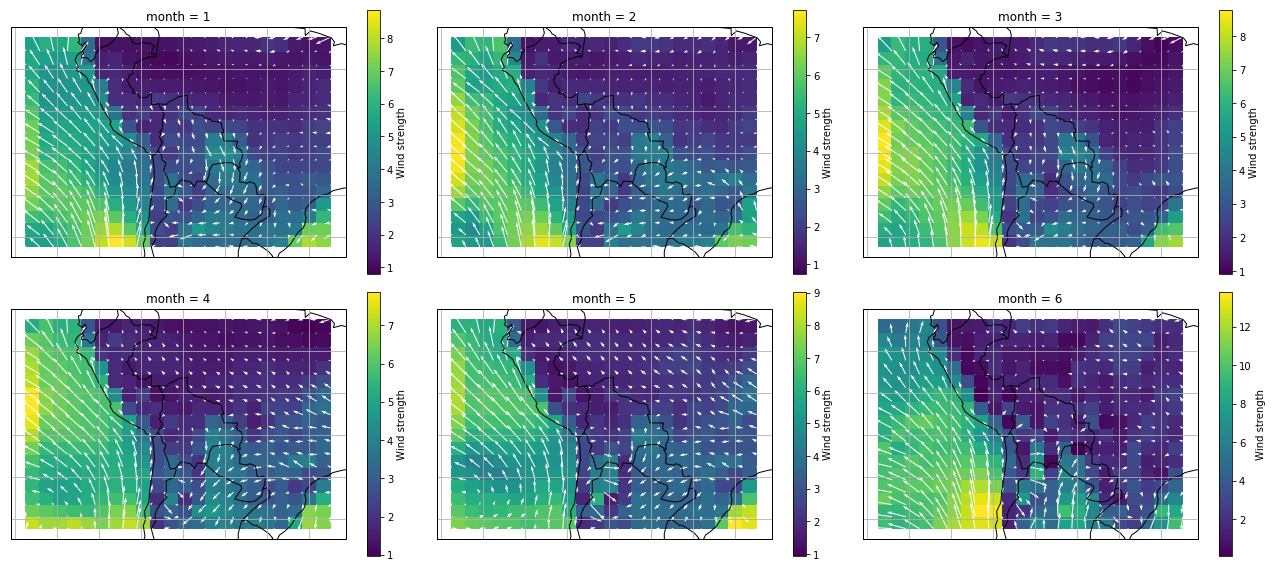

In [188]:
fig, axs = sp_map(2,3, figsize=[18,8])

W_mm = ds[{BT:0}].groupby('XTIME.month').mean(XT)
#W_mean = ds[T][{BT:0}].mean(XT)
#T_dev = T_mm- T_mean
#T_mm.sel(month=1)
for mo, ax in zip(T_mm['month'], axs.flatten()):
    _dsm = W_mm.sel(month=mo)
    _dsm[WS].plot(x=XLO, y=XLA,ax=ax, transform=ccrs.PlateCarree())
    ax.quiver(_dsm[XLO], _dsm[XLA], _dsm['U'],_dsm['V'], transform=ccrs.PlateCarree(), color='w')
    
    add_map_features(ax)
plt.tight_layout()

In [ ]:
_ds = ds.copy()
_ds['south_north'] = ds[XLA][:,0]
_ds = _ds.rename({'south_north':'lat'})
_ds[U].mean([XT,'west_east']).plot.contourf(robust=True)

In [161]:
ds_dmax = ds.groupby('XTIME.day').max()
ds_dmin = ds.groupby('XTIME.day').min()

In [164]:
ds_dmax

<xarray.Dataset>
Dimensions:        (bottom_top: 10, day: 31, south_north: 17, west_east: 23)
Coordinates:
    XLONG          (south_north, west_east) float32 -88.401634 ... -44.987724
    XLAT           (south_north, west_east) float32 -31.348223 ... -1.4679687
  * day            (day) int64 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    P              (day, bottom_top, south_north, west_east) float32 2556.7764 ... 0.97253907
    V              (day, bottom_top, south_north, west_east) float32 4.923255 ... 3.1154273
    U              (day, bottom_top, south_north, west_east) float32 7.0364075 ... 8.876934
    T              (day, bottom_top, south_north, west_east) float32 -5.985603 ... 137.6325
    T_C            (day, bottom_top, south_north, west_east) float32 21.014404 ... 164.6325
    Wind strength  (day, bottom_top, south_north, west_east) float32 10.250391 ... 8.922911

In [ ]:
fig, axsm =sp_map(2,2, figsize = [12,7])
axs = axsm.flatten()
_max = ds_dmax[{BT:0}].mean('day')
_min = ds_dmin[{BT:0}].mean('day')
kwargs = { 'transform':ccrs.PlateCarree()}
_max[T_C].plot(x=XLO, y=XLA, ax=axs[0],**kwargs )
_min[T_C].plot(x=XLO, y=XLA,ax=axs[1],**kwargs )
axs[0].set_title('T max')
axs[1].set_title('T min')
_max[WS].plot(x=XLO, y=XLA,ax=axs[2],**kwargs )
_min[WS].plot(x=XLO, y=XLA,ax=axs[3],**kwargs )
axs[2].set_title('Wind max')
axs[3].set_title('Wind min')
for ax in axs:
    add_map_features(ax)
plt.tight_layout()

In [191]:
CHC ={'XLAT':-16.20, 'XLONG':-40.6} 
marine = {'XLAT':-16.44, 'XLONG': -72.24}
amazonas = {'XLAT':-5.08, 'XLONG':-64.44}#'29.4"W

In [217]:
locations={'CHC':CHC, 'marine':marine, 'amazonas':amazonas}

In [214]:
locations = ['marine', 'CHC','amazonas']
ds2 = ds.copy()
ds2['south_north'] = ds2.XLAT[:,0]
ds2['west_east']=ds2.XLONG[0,:]
ds2=ds2.rename({'south_north':'lat','west_east':'lon'})

In [ ]:
li=[]
for loc in locations:
    li.append(ds2.sel(lat=locations[loc]['XLAT'], lon=locations[loc]['XLONG'] , method='nearest'))

ds_loc= xr.concat(li, dim='location')#{'LOC':list(locations.keys())})
ds_loc['location']=list(locations.keys())
ds_loc

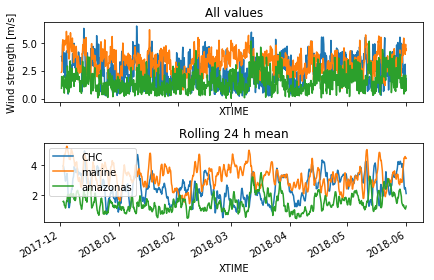

In [276]:
fig, axs = plt.subplots(2,1, sharex=True)
for loc in ds_loc.location.values:
    ds_loc[{BT:0}]['Wind strength'].sel(location=loc).plot(label=loc,ax=axs[0])
    axs[0].set_title('All values')
    ds_loc[{BT:0}]['Wind strength'].sel(location=loc).rolling(XTIME=8).mean().plot(label=loc,ax=axs[1])
    axs[1].set_title('Rolling 24 h mean')
    
axs[1].legend()
plt.tight_layout()

## Convert to pandas:

In [259]:
df_loc = ds_loc[{BT:0}].to_dataframe()

In [277]:
df_loc

P         V         U         T  \
XTIME               location                                              
2017-12-02 00:00:00 CHC       1229.843140 -3.019325 -2.255648 -1.541383   
                    marine    1399.709106  2.016470 -1.227415 -5.899125   
                    amazonas   613.381592  0.821042 -0.427001 -0.980686   
2017-12-02 03:00:00 CHC       1167.614380 -2.977887 -2.286594 -1.595747   
                    marine    1316.254395  1.619147 -1.793550 -6.657432   
...                                   ...       ...       ...       ...   
2018-05-31 21:00:00 marine    1254.000977  3.208141 -2.824981 -9.469061   
                    amazonas  1065.756226  0.457274 -0.534182  1.111743   
2018-06-01 00:00:00 CHC       1620.141602  0.879737 -1.560841 -0.933029   
                    marine    1253.637451  3.275094 -2.987550 -9.736329   
                    amazonas  1098.147217  0.734984 -1.417634 -0.264313   

                                   XLAT      XLONG        T_C  Wind strength  \
XTIME               location                                                   
2017-12-02 00:00:00 CHC      -16.999245 -44.987724  25.458618       3.768856   
                    marine   -16.999245 -72.614754  21.100861       2.360656   
                    amazonas  -5.406621 -64.721321  26.019318       0.925441   
2017-12-02 03:00:00 CHC      -16.999245 -44.987724  25.404266       3.754507   
                    marine   -16.999245 -72.614754  20.342560       2.416291   
...                                 ...        ...        ...            ...   
2018-05-31 21:00:00 marine   -16.999245 -72.614754  17.530945       4.274656   
                    amazonas  -5.406621 -64.721321  28.111755       0.703171   
2018-06-01 00:00:00 CHC      -16.999245 -44.987724  26.066986       1.791692   
                    marine   -16.999245 -72.614754  17.263672       4.433023   
                    amazonas  -5.406621 -64.721321  26.735687       1.596836   

                                    lat        lon  
XTIME               location                        
2017-12-02 00:00:00 CHC      -16.999245 -44.987724  
                    marine   -16.999245 -72.614754  
                    amazonas  -5.406621 -64.721321  
2017-12-02 03:00:00 CHC      -16.999245 -44.987724  
                    marine   -16.999245 -72.614754  
...                                 ...        ...  
2018-05-31 21:00:00 marine   -16.999245 -72.614754  
                    amazonas  -5.406621 -64.721321  
2018-06-01 00:00:00 CHC      -16.999245 -44.987724  
                    marine   -16.999245 -72.614754  
                    amazonas  -5.406621 -64.721321  

[4347 rows x 10 columns]